# Solving Eigenvalue Problems with FFNN Models

In this notebook, an FFNN model is employed within the TensorFlow framework to learn the solution to the nonlinear, coupled ODE, presented by Yi et. al in the article from [Computers and Mathematics with Applications 47, 1155 (2004)](https://www.sciencedirect.com/science/article/pii/S0898122104901101), describing the state of a CTRNN model. Given a real symmetric matrix $A$ in the source term, the temporal dynamic described by this ODE has convergence properties to the largest eigenvalue $\lambda$, given that the initial vector $\mathbf{x}_0$ is not orthogonal to the eigenspace of $\lambda$. If $\mathbf{x}_0$ is not orthogonal to the eigenspace of the smallest eigenvalue $\sigma$, replacing $A$ with $-A$ yields the smallest eigenvalue.

The aim is to design a FFNN model suitable for solving this ODE, and check if it succeeds in computing both the largest and smallest eigenvalue for some benchmark $3\times 3$ and $6\times 6$ real symmetric matrices. We will also try choosing $\mathbf{x}_0$ orthogonal to the eigenspace corresponding to the largest eigenvalue, to make the network converge to an eigenvalue different from the largest. This starting point will itself be an eigenvector.

In order to assess the FFNN model, we will compare the result with those from Euler's method for solving the same ODE and Numpy's ``linalg.eig`` which directly computes the eigenvalues of the matrix $A$. 

Unfortunately, we found tensorflow objects (such as tensorflow functions) hard to reuse. There is therefore much repetitive code in the code cells below. This notebook is organized such that each code cell have all the necessary code, except imports, to solve a particular problem. To better distinguish what problem a particular code cell solves, we have added headers that explains the problem at hand.

### Configure notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Import code from src
sys.path.insert(0, '../src/')
from tools import fig_path

tf.keras.backend.set_floatx("float64")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)

## Benchmark Problem 1: Largest Eigenvalue of a 3x3 Matrix 

Step: 1, Loss: 1.2770721346990614
Step: 100, Loss: 0.13565214997579497
Step: 200, Loss: 0.04199647585450178
Step: 300, Loss: 0.023209714150359436
Step: 400, Loss: 0.013092356785413612
Step: 500, Loss: 0.010640508899773514
Step: 600, Loss: 0.003952909534331961
Step: 700, Loss: 0.0019266454646665301
Step: 800, Loss: 0.002934178533324888
Step: 900, Loss: 0.005554600359764925
Step: 1000, Loss: 0.0003804426886493388
Step: 1100, Loss: 0.00017570805611972687
Step: 1200, Loss: 0.002008596970728493
Step: 1300, Loss: 0.0001812207837729587
Step: 1400, Loss: 8.379975233079569e-05
Step: 1500, Loss: 0.0019742825027715583
Step: 1600, Loss: 4.782022263943694e-05
Step: 1700, Loss: 0.0015147606807516417
Step: 1800, Loss: 0.0010111974906577947
Step: 1900, Loss: 7.996037658441941e-05
Step: 2000, Loss: 0.00010105130523549834



A = [[3. 2. 4.]
 [2. 0. 2.]
 [4. 2. 3.]]
x0 = [1. 0. 0.]
Eigvals Numpy: [-1.  8. -1.]
Max Eigval Numpy 8.0
Eigvec Numpy: [0.66666667 0.33333333 0.66666667]
Final Rayleigh Quotient Euler 7.999999830318936
Final Rayleigh Quotient FFNN 7.999997207962974
Absolute Error Euler: 1.6968106386627824e-07
Absolute Error FFNN: 2.7920370255785087e-06
Percent Error Euler 2.121013298328478e-06
Percent Error FFNN 3.490046281973136e-05


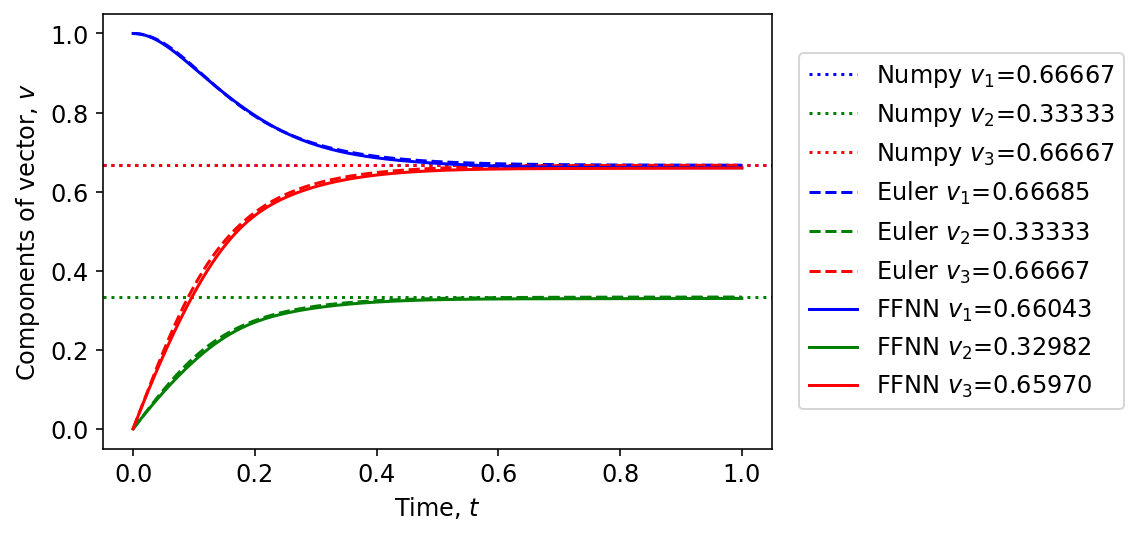

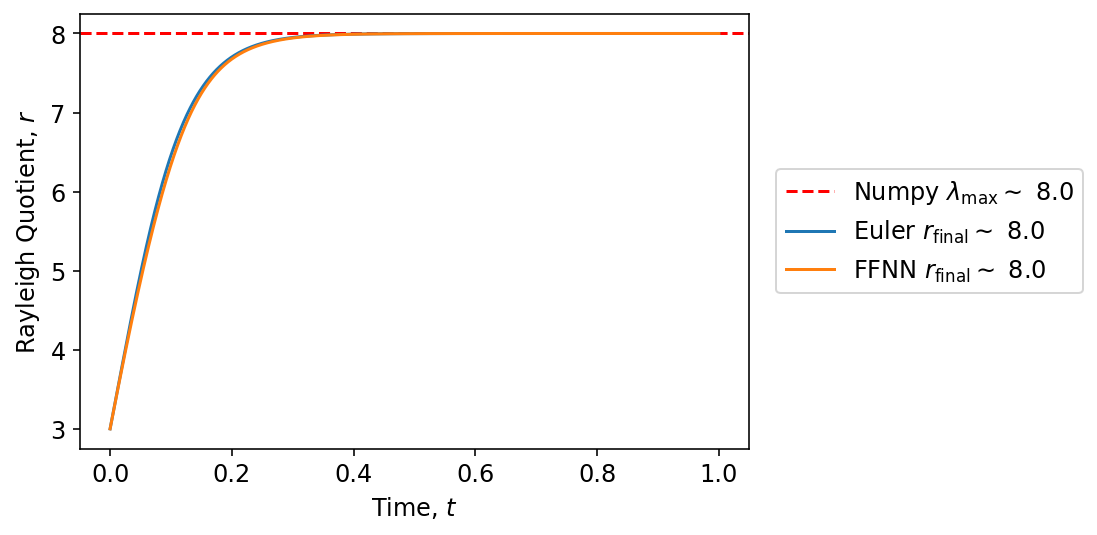

In [62]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 10000   # number of time points
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
x0 = np.array([1, 0, 0])
x0 = x0 / np.linalg.norm(x0)
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Eigvec Numpy:', w[:,1])
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.max(v) - eig_euler[-1]) / np.max(v)))
print('Percent Error FFNN', 100 * np.abs((np.max(v) - eig_nn.numpy()[-1]) / np.max(v)))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_benchrun1.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun1.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 2: Smallest Eigenvalue of a 3x3 Matrix 

Step: 1, Loss: 0.11475625842553484
Step: 100, Loss: 0.007679473992883806
Step: 200, Loss: 0.0034378571693642374
Step: 300, Loss: 0.0011806430123443832
Step: 400, Loss: 0.00023968403639513587
Step: 500, Loss: 9.616829890006653e-05
Step: 600, Loss: 6.213921229360303e-05
Step: 700, Loss: 4.292685475592326e-05
Step: 800, Loss: 2.979373848693897e-05
Step: 900, Loss: 2.0745933385775983e-05
Step: 1000, Loss: 1.4603613707477677e-05
Step: 1100, Loss: 1.0485661287569419e-05
Step: 1200, Loss: 7.741241040075055e-06
Step: 1300, Loss: 5.905525777360118e-06
Step: 1400, Loss: 4.656018154465057e-06
Step: 1500, Loss: 3.7773919915013625e-06
Step: 1600, Loss: 3.133031807334271e-06
Step: 1700, Loss: 2.6407617575996085e-06
Step: 1800, Loss: 2.252892126811718e-06
Step: 1900, Loss: 1.9415724888212233e-06
Step: 2000, Loss: 1.6894607230120277e-06



A = [[2. 1. 0.]
 [1. 2. 1.]
 [0. 1. 2.]]
x0 = [ 0.81649658 -0.40824829  0.40824829]
Eigvals Numpy: [3.41421356 2.         0.58578644]
Min Eigval Numpy 0.5857864376269049
Eigvec Numpy: [ 7.07106781e-01  4.05925293e-16 -7.07106781e-01]
Final Rayleigh Quotient Euler 0.5857937106592918
Final Rayleigh Quotient FFNN 0.585792567416771
Absolute Error Euler: 2.8284198517137997
Absolute Error FFNN: 2.8284209949563204
Percent Error Euler 82.84249945243236
Percent Error FFNN 82.84253293723054


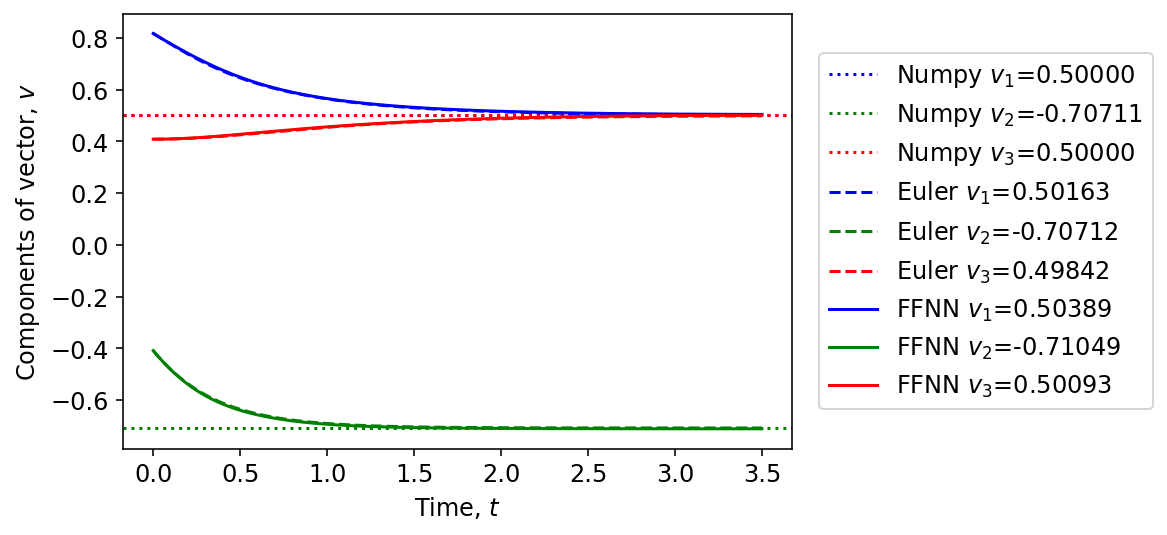

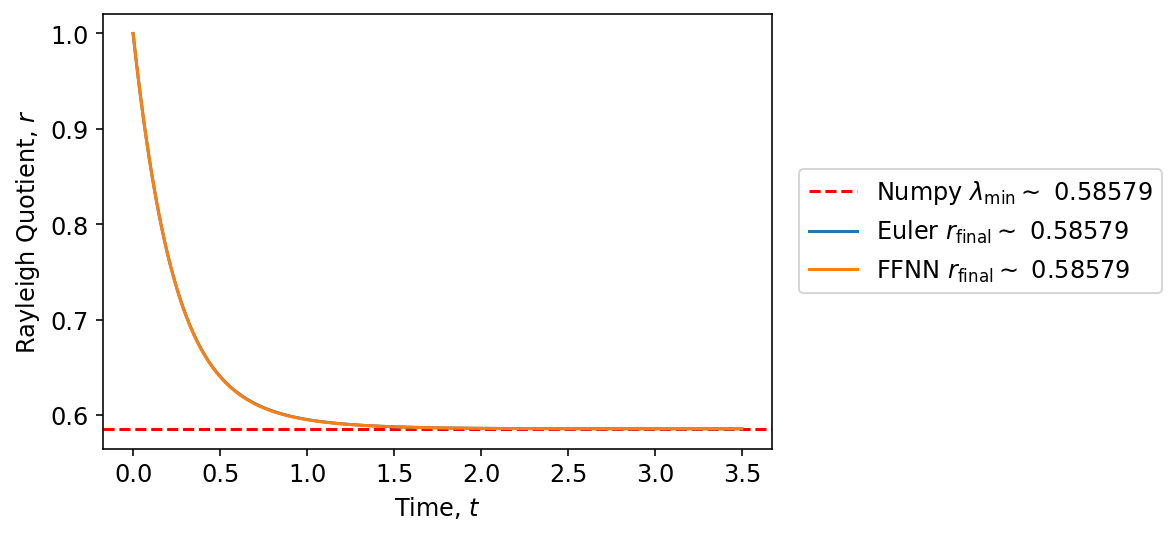

In [63]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 3.5    # Final time

# Problem formulation for Euler
N = 10000   # number of time points
A = np.array([[2., 1., 0.], [1., 2., 1.], [0., 1., 2.]])
x0 = np.array([2, -1, 1])
x0 = x0 / np.linalg.norm(x0)
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, -A_tf, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(-A, x0, T, N)
eig_euler = -eig_euler

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Min Eigval Numpy', np.min(v))
print('Eigvec Numpy:', w[:, 1])
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.max(v) - eig_euler[-1]) / np.max(v)))
print('Percent Error FFNN', 100 * np.abs((np.max(v) - eig_nn.numpy()[-1]) / np.max(v)))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(w[0, 2], color='b', ls=':', label=f'Numpy $v_1$={w[0, 2]:.5f}')
ax0.axhline(w[1, 2], color='g', ls=':', label=f'Numpy $v_2$={w[1, 2]:.5f}')
ax0.axhline(w[2, 2], color='r', ls=':', label=f'Numpy $v_3$={w[2, 2]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_benchrun2.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.min(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{min}} \\sim$ " + \
    str(round(np.min(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun2.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 3:  Initial Vector Orthogonal to Eigenvector Corresponding to Largest Eigenvalue

Step: 1, Loss: 0.10024895796525009
Step: 100, Loss: 1.5525661867869287e-06
Step: 200, Loss: 1.7499758619598653e-07
Step: 300, Loss: 4.1059442723897815e-08
Step: 400, Loss: 8.780811488883317e-09
Step: 500, Loss: 1.7461983193502221e-09
Step: 600, Loss: 3.904122745563102e-10
Step: 700, Loss: 1.7058961438843962e-10
Step: 800, Loss: 1.415529883863925e-10
Step: 900, Loss: 1.38460342026388e-10
Step: 1000, Loss: 1.3815394930537115e-10
Step: 1100, Loss: 2.1011653248677447e-05
Step: 1200, Loss: 8.667324377521186e-09
Step: 1300, Loss: 1.7283250349998419e-09
Step: 1400, Loss: 6.619144322608466e-10
Step: 1500, Loss: 3.607357649304017e-10
Step: 1600, Loss: 2.5137038891781084e-10
Step: 1700, Loss: 2.1012263421512846e-10
Step: 1800, Loss: 1.9521216928268233e-10
Step: 1900, Loss: 1.9009815428221896e-10
Step: 2000, Loss: 1.88379096319084e-10



A = [[ 3  1 -1]
 [ 1  3 -1]
 [-1 -1  5]]
x0 = [-0.70710678  0.70710678  0.        ]
Eigvals Numpy: [6. 2. 3.]
Final Rayleigh Quotient Euler 2.0000000000000004
Final Rayleigh Quotient FFNN 2.000000000003523
Absolute Error Euler: 3.552713678800501e-15
Absolute Error FFNN: 3.526068326209497e-12
Percent Error Euler 1.7763568394002532e-13
Percent Error FFNN 1.7630341631047514e-10


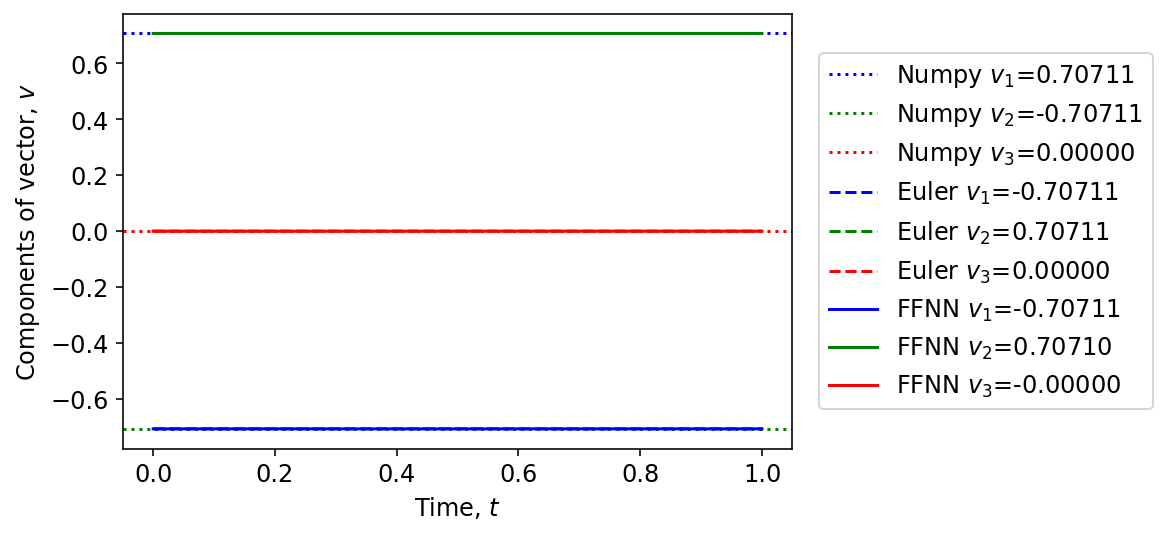

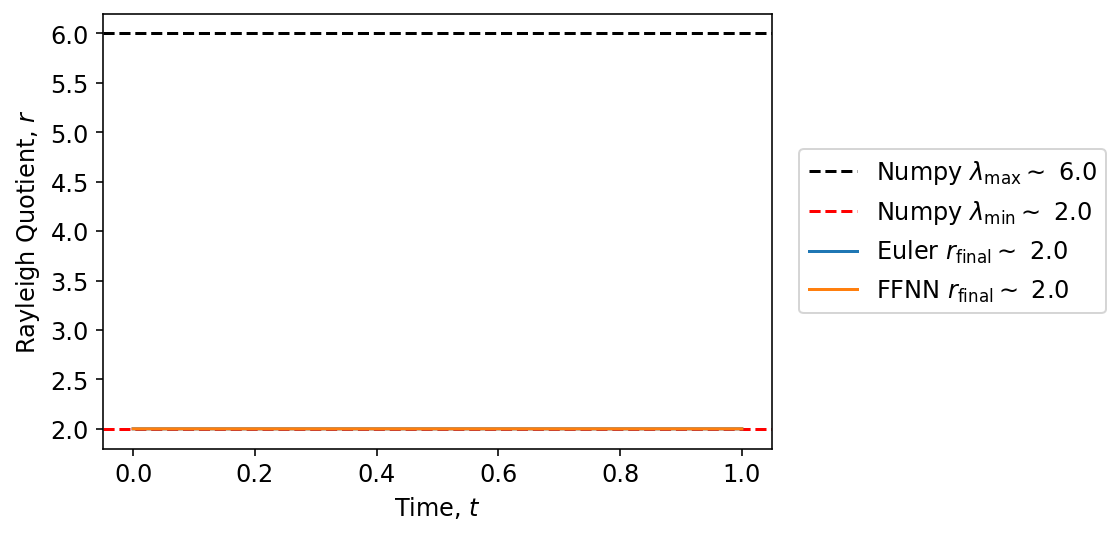

In [64]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 10000   # number of time points
A = np.array([[3, 1, -1], [1, 3, -1], [-1, -1, 5]])
x0 = np.array([-1, 1, 0])
x0 = x0 / np.linalg.norm(x0)
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, -A_tf, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(-A, x0, T, N)
eig_euler = -eig_euler

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.min(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.min(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.min(v) - eig_euler[-1]) / np.min(v)))
print('Percent Error FFNN', 100 * np.abs((np.min(v) - eig_nn.numpy()[-1]) / np.min(v)))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(-w[0, 1], color='b', ls=':', label=f'Numpy $v_1$={-w[0, 1]:.5f}')
ax0.axhline(-w[1, 1], color='g', ls=':', label=f'Numpy $v_2$={-w[1, 1]:.5f}')
ax0.axhline(-w[2, 1], color='r', ls=':', label=f'Numpy $v_3$={-w[2, 1]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_benchrun3.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='k', ls='--')
ax.axhline(np.min(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy1 = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_numpy2 = "Numpy $\\lambda_{\\mathrm{min}} \\sim$ " + \
    str(round(np.min(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy1, lgd_numpy2, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun3.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 4: 6x6 matrix and the effect of number of time points

### a-run: T=10, N=51 (Euler), Nt=5 (FFNN)

Step: 1, Loss: 1.507756897411548
Step: 100, Loss: 0.028702366661165934
Step: 200, Loss: 0.014112814557573124
Step: 300, Loss: 0.001325194922073492
Step: 400, Loss: 0.00034006720987815223
Step: 500, Loss: 0.0001772991136720474
Step: 600, Loss: 0.00011090062574029465
Step: 700, Loss: 7.492433520906591e-05
Step: 800, Loss: 5.321307977532388e-05
Step: 900, Loss: 3.9331525712532446e-05
Step: 1000, Loss: 3.0119015153967915e-05
Step: 1100, Loss: 2.3825109372399487e-05
Step: 1200, Loss: 1.9401506690098962e-05
Step: 1300, Loss: 1.6191289696544017e-05
Step: 1400, Loss: 1.3775280310843418e-05
Step: 1500, Loss: 1.1886031415012848e-05
Step: 1600, Loss: 1.0354376048004386e-05
Step: 1700, Loss: 9.074255968850687e-06
Step: 1800, Loss: 7.979326018124817e-06
Step: 1900, Loss: 7.02766537601808e-06
Step: 2000, Loss: 6.192080154447724e-06



A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.19137732 -1.72491783  0.45168062 -1.08191235  0.15037505]
 [ 0.30750289 -0.43487183  0.45168062 -0.2257763   0.22161311 -1.24122956]
 [-0.38926805 -0.17624755 -1.08191235  0.22161311 -0.60063869  0.26542558]
 [-0.41792178  0.69327422  0.15037505 -1.24122956  0.26542558 -1.22084365]]
x0 = [0.20819531 0.34735924 0.3651539  0.12346636 0.6475964  0.51771987]
Eigvals Numpy: [-3.13078844  1.82431291  1.21134579 -0.81694732  0.15215664 -1.74810717]
Max Eigval Numpy 1.8243129103884215
Final Rayleigh Quotient Euler 1.8243129103406113
Final Rayleigh Quotient FFNN 1.824232389729373
Absolute Error Euler: 4.781020024324789e-11
Absolute Error FFNN: 8.052065904839978e-05


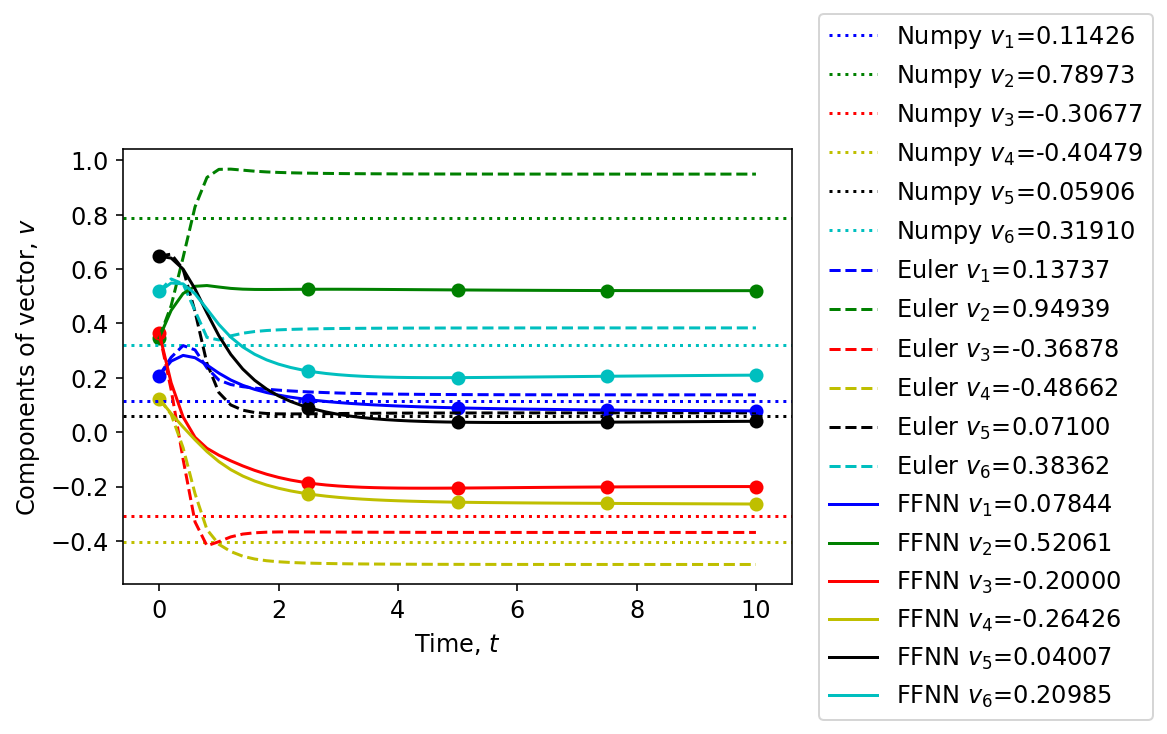

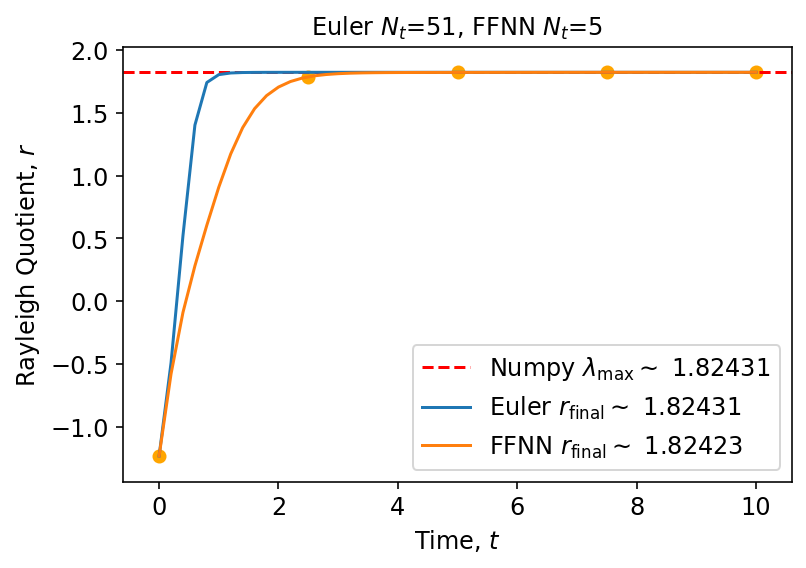

In [67]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6    # Dimension
T = 10    # Final time
N = 51   # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 5   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.axhline(w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={w[3, np.argmax(v)]:.5f}')
ax0.axhline(w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={w[4, np.argmax(v)]:.5f}')
ax0.axhline(w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.scatter(t_tf, g_points[:, 0], color='b')
ax0.scatter(t_tf, g_points[:, 1], color='g')
ax0.scatter(t_tf, g_points[:, 2], color='r')
ax0.scatter(t_tf, g_points[:, 3], color='y')
ax0.scatter(t_tf, g_points[:, 4], color='k')
ax0.scatter(t_tf, g_points[:, 5], color='c')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_run66a.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.scatter(t_tf, eig_nn_points, color='orange')
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66a.pdf"), bbox_inches='tight')
plt.show()

### b-run: T=10, N=101 (Euler), Nt=11 (FFNN)

Step: 1, Loss: 1.4257049914502256
Step: 100, Loss: 0.019537108364591507
Step: 200, Loss: 0.015339344190948562
Step: 300, Loss: 0.013067991139391562
Step: 400, Loss: 0.008995917659635868
Step: 500, Loss: 0.004412657247088982
Step: 600, Loss: 0.0017075920610810514
Step: 700, Loss: 0.0007461702780734093
Step: 800, Loss: 0.00042046419775318737
Step: 900, Loss: 0.0002770856241377915
Step: 1000, Loss: 0.00019469650436686946
Step: 1100, Loss: 0.0001395588617908816
Step: 1200, Loss: 0.00010017693685901776
Step: 1300, Loss: 7.189624856097091e-05
Step: 1400, Loss: 5.224311819659665e-05
Step: 1500, Loss: 3.918269837614679e-05
Step: 1600, Loss: 3.071004255994257e-05
Step: 1700, Loss: 2.5098068795367646e-05
Step: 1800, Loss: 2.1145698221728764e-05
Step: 1900, Loss: 1.815486657166035e-05
Step: 2000, Loss: 1.576014469880334e-05



A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.19137732 -1.72491783  0.45168062 -1.08191235  0.15037505]
 [ 0.30750289 -0.43487183  0.45168062 -0.2257763   0.22161311 -1.24122956]
 [-0.38926805 -0.17624755 -1.08191235  0.22161311 -0.60063869  0.26542558]
 [-0.41792178  0.69327422  0.15037505 -1.24122956  0.26542558 -1.22084365]]
x0 = [0.20819531 0.34735924 0.3651539  0.12346636 0.6475964  0.51771987]
Eigvals Numpy: [-3.13078844  1.82431291  1.21134579 -0.81694732  0.15215664 -1.74810717]
Max Eigval Numpy 1.8243129103884215
Final Rayleigh Quotient Euler 1.8243129083282248
Final Rayleigh Quotient FFNN 1.824259429563859
Absolute Error Euler: 2.060196679920523e-09
Absolute Error FFNN: 5.34808245624685e-05


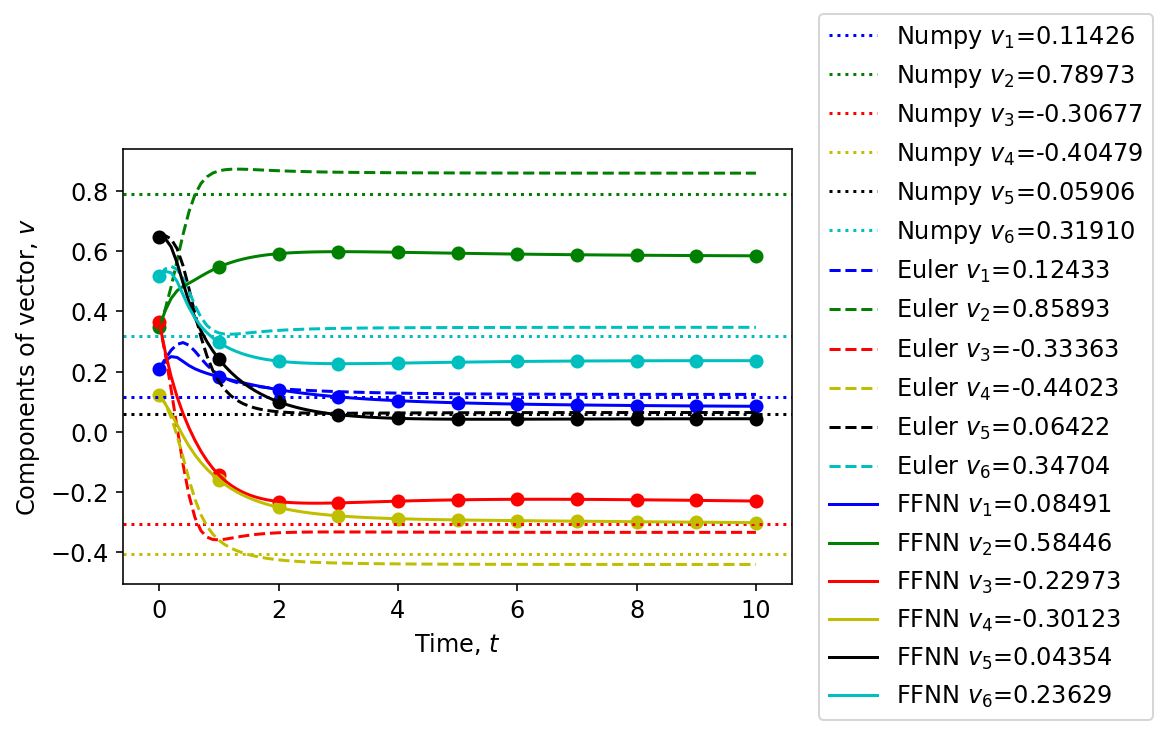

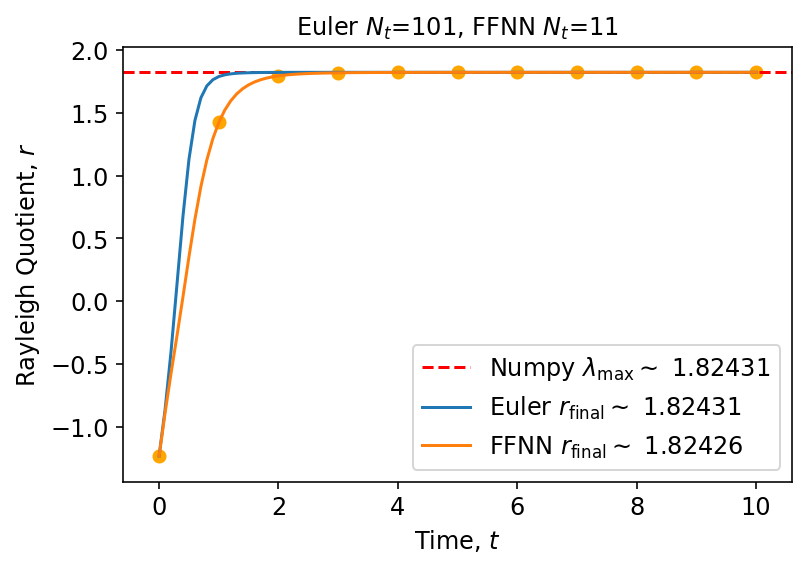

In [68]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6    # Dimension
T = 10    # Final time
N = 101   # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 11   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.axhline(w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={w[3, np.argmax(v)]:.5f}')
ax0.axhline(w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={w[4, np.argmax(v)]:.5f}')
ax0.axhline(w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.scatter(t_tf, g_points[:, 0], color='b')
ax0.scatter(t_tf, g_points[:, 1], color='g')
ax0.scatter(t_tf, g_points[:, 2], color='r')
ax0.scatter(t_tf, g_points[:, 3], color='y')
ax0.scatter(t_tf, g_points[:, 4], color='k')
ax0.scatter(t_tf, g_points[:, 5], color='c')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_run66b.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.scatter(t_tf, eig_nn_points, color='orange')
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66b.pdf"), bbox_inches='tight')
plt.show()

### c-run: T=10, N=501 (Euler), Nt=51 (FFNN)

Step: 1, Loss: 1.3906203496223715
Step: 100, Loss: 0.010730036465785287
Step: 200, Loss: 0.006746229087721714
Step: 300, Loss: 0.006290440481653594
Step: 400, Loss: 0.006022745538174261
Step: 500, Loss: 0.005640676667918492
Step: 600, Loss: 0.005063054334056204
Step: 700, Loss: 0.004314002001306835
Step: 800, Loss: 0.003643065667368412
Step: 900, Loss: 0.003181771035841181
Step: 1000, Loss: 0.00283695355532121
Step: 1100, Loss: 0.002518678562935475
Step: 1200, Loss: 0.002200304560633019
Step: 1300, Loss: 0.0018844039919535065
Step: 1400, Loss: 0.0015832394081289247
Step: 1500, Loss: 0.00130529281677943
Step: 1600, Loss: 0.001056257111535443
Step: 1700, Loss: 0.0008419447851497148
Step: 1800, Loss: 0.0006654319190755752
Step: 1900, Loss: 0.0005248485434488057
Step: 2000, Loss: 0.0004145570698620124



A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.19137732 -1.72491783  0.45168062 -1.08191235  0.15037505]
 [ 0.30750289 -0.43487183  0.45168062 -0.2257763   0.22161311 -1.24122956]
 [-0.38926805 -0.17624755 -1.08191235  0.22161311 -0.60063869  0.26542558]
 [-0.41792178  0.69327422  0.15037505 -1.24122956  0.26542558 -1.22084365]]
x0 = [0.20819531 0.34735924 0.3651539  0.12346636 0.6475964  0.51771987]
Eigvals Numpy: [-3.13078844  1.82431291  1.21134579 -0.81694732  0.15215664 -1.74810717]
Max Eigval Numpy 1.8243129103884215
Final Rayleigh Quotient Euler 1.824312895338423
Final Rayleigh Quotient FFNN 1.8242807878616998
Absolute Error Euler: 1.5049998580707324e-08
Absolute Error FFNN: 3.212252672168958e-05


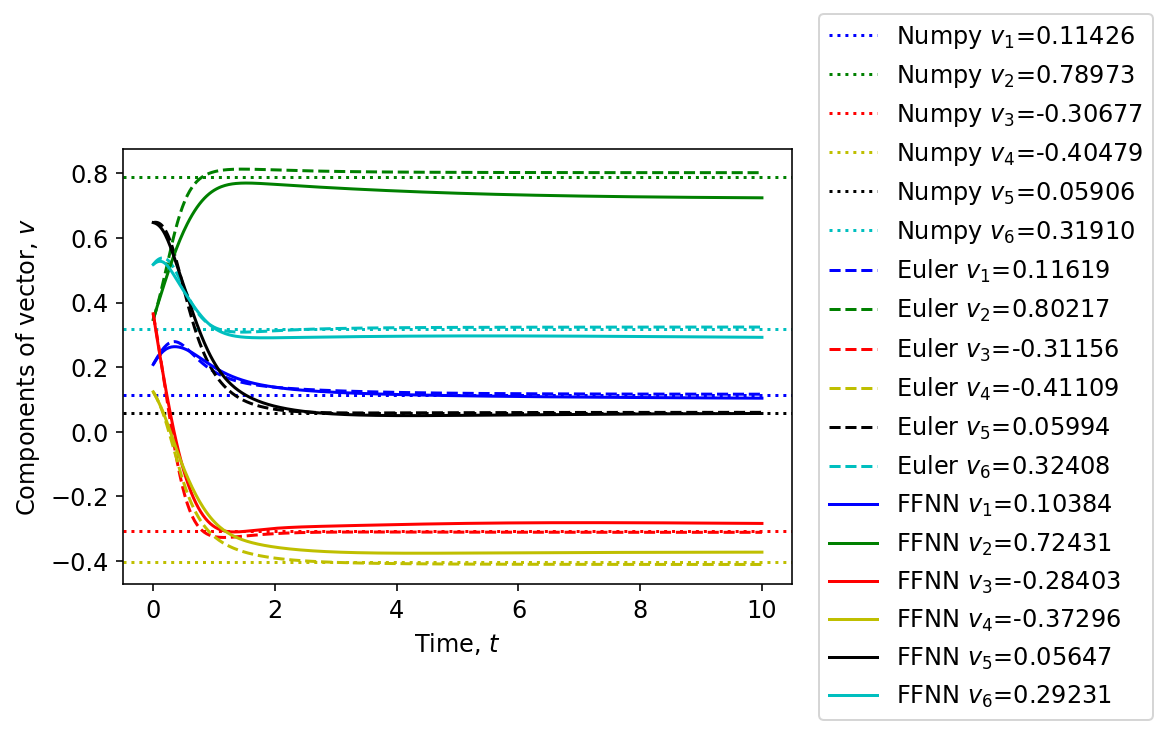

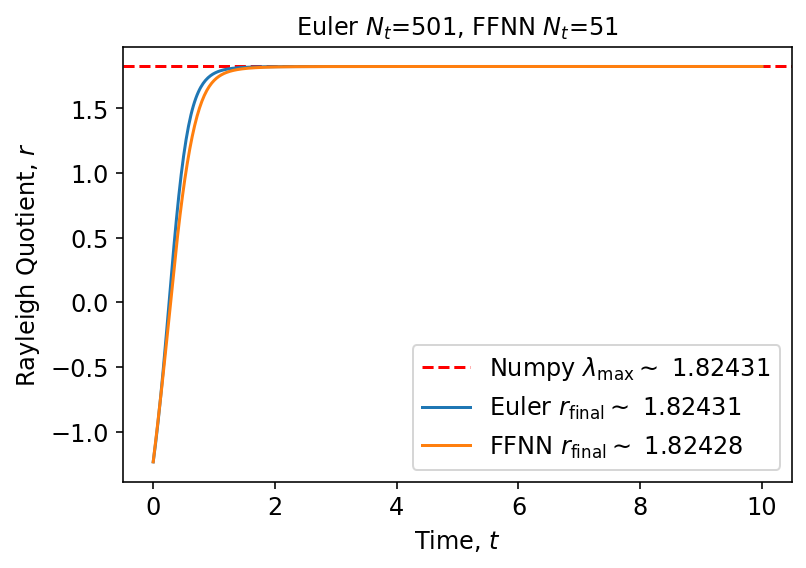

In [69]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6    # Dimension
T = 10    # Final time
N = 501   # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 51   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.axhline(w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={w[3, np.argmax(v)]:.5f}')
ax0.axhline(w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={w[4, np.argmax(v)]:.5f}')
ax0.axhline(w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_run66c.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66c.pdf"), bbox_inches='tight')
plt.show()

### d-run: T=10, N=1001 (Euler), Nt=101 (FFNN)

Step: 1, Loss: 1.3878186241159738
Step: 100, Loss: 0.009623530588994676
Step: 200, Loss: 0.005803311458425383
Step: 300, Loss: 0.005327170969956883
Step: 400, Loss: 0.005119881973898079
Step: 500, Loss: 0.004848246685806769
Step: 600, Loss: 0.004444425542282935
Step: 700, Loss: 0.003868116037728768
Step: 800, Loss: 0.0032513566677788218
Step: 900, Loss: 0.0027907751499013115
Step: 1000, Loss: 0.0024853981176692777
Step: 1100, Loss: 0.00224046985714899
Step: 1200, Loss: 0.002009554219131043
Step: 1300, Loss: 0.0017814415170680415
Step: 1400, Loss: 0.0015582181239297897
Step: 1500, Loss: 0.0013443117640917677
Step: 1600, Loss: 0.0011432760053015697
Step: 1700, Loss: 0.0009587888650219614
Step: 1800, Loss: 0.0007947270834195575
Step: 1900, Loss: 0.0006537368457031295
Step: 2000, Loss: 0.0005361216729334457



A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.19137732 -1.72491783  0.45168062 -1.08191235  0.15037505]
 [ 0.30750289 -0.43487183  0.45168062 -0.2257763   0.22161311 -1.24122956]
 [-0.38926805 -0.17624755 -1.08191235  0.22161311 -0.60063869  0.26542558]
 [-0.41792178  0.69327422  0.15037505 -1.24122956  0.26542558 -1.22084365]]
x0 = [0.20819531 0.34735924 0.3651539  0.12346636 0.6475964  0.51771987]
Eigvals Numpy: [-3.13078844  1.82431291  1.21134579 -0.81694732  0.15215664 -1.74810717]
Max Eigval Numpy 1.8243129103884215
Final Rayleigh Quotient Euler 1.8243128919138343
Final Rayleigh Quotient FFNN 1.8242767653367895
Absolute Error Euler: 1.8474587193395564e-08
Absolute Error FFNN: 3.614505163196391e-05


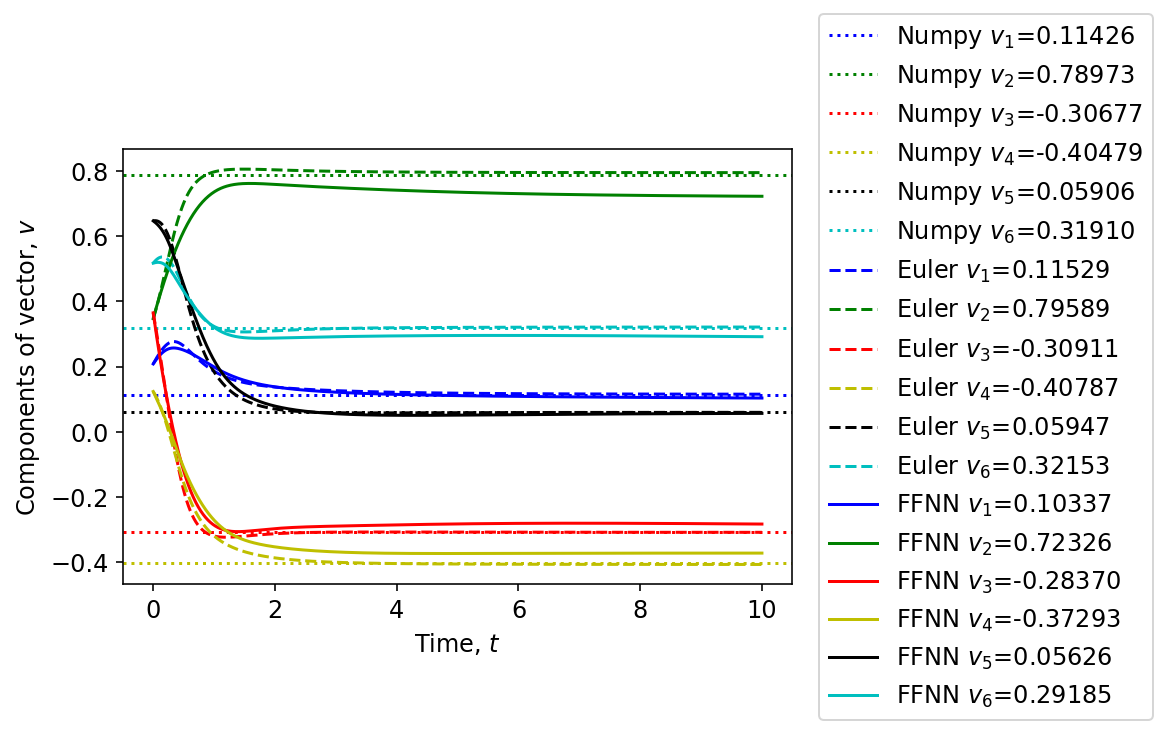

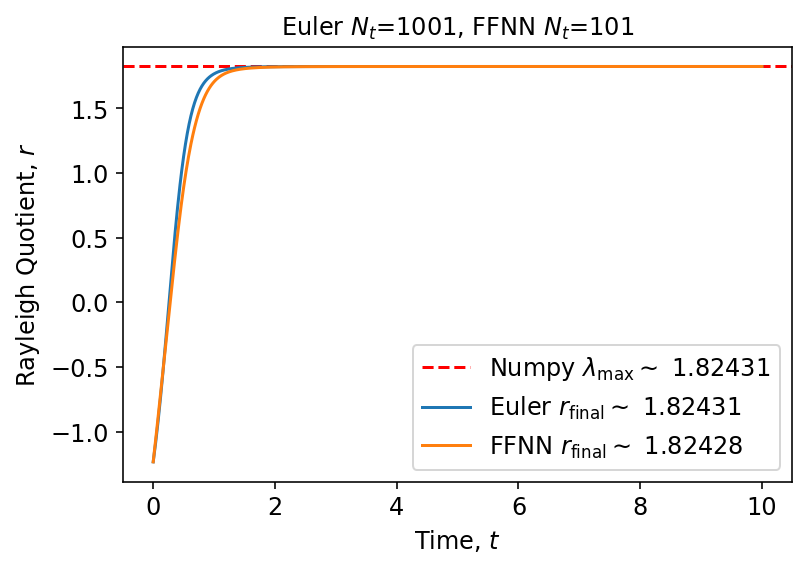

In [70]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6     # Dimension
T = 10    # Final time
N = 1001  # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 101   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.axhline(w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={w[3, np.argmax(v)]:.5f}')
ax0.axhline(w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={w[4, np.argmax(v)]:.5f}')
ax0.axhline(w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_run66d.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66d.pdf"), bbox_inches='tight')
plt.show()

## Final test: see if observations hold for another random 6x6 matrix

Step: 1, Loss: 0.17427765412336124
Step: 100, Loss: 0.01440107466726588
Step: 200, Loss: 0.0009669162016809005
Step: 300, Loss: 0.00027700748515531725
Step: 400, Loss: 0.00010447777332924139
Step: 500, Loss: 3.7648158765240805e-05
Step: 600, Loss: 5.5238783843016524e-05
Step: 700, Loss: 1.5450472322830796e-05
Step: 800, Loss: 0.0004873936830317055
Step: 900, Loss: 2.7040015886763583e-05
Step: 1000, Loss: 1.811254597170781e-05
Step: 1100, Loss: 6.339673818669149e-05
Step: 1200, Loss: 0.00040533094845525674
Step: 1300, Loss: 3.383981077410725e-05
Step: 1400, Loss: 9.809809470004766e-05
Step: 1500, Loss: 0.0001823157653785143
Step: 1600, Loss: 4.257477012381276e-05
Step: 1700, Loss: 6.993971007060503e-06
Step: 1800, Loss: 2.1139871339944264e-05
Step: 1900, Loss: 0.00010983014862668729
Step: 2000, Loss: 7.281329550567508e-06



A = [[ 0.25739993 -0.20514642 -1.02358291 -0.79087729  0.45625895 -0.91044408]
 [-0.20514642  2.01019925  0.20038802 -0.66441622  0.26887196  0.63158454]
 [-1.02358291  0.20038802  0.49291085 -0.05513643  0.91357786 -0.37836315]
 [-0.79087729 -0.66441622 -0.05513643 -0.16082969  1.39298332 -0.10596857]
 [ 0.45625895  0.26887196  0.91357786  1.39298332  0.39490664  0.22527344]
 [-0.91044408  0.63158454 -0.37836315 -0.10596857  0.22527344  1.65904873]]
x0 = [0.38533209 0.28264731 0.49964367 0.27435969 0.46057678 0.48433632]
Eigvals Numpy: [-2.31573761 -0.28832574  2.78162892  0.83496949  1.5449505   2.09615013]
Max Eigval Numpy 2.7816289230026476
Final Rayleigh Quotient Euler 2.781628300433462
Final Rayleigh Quotient FFNN 2.781605803832831
Absolute Error Euler: 6.225691855377136e-07
Absolute Error FFNN: 2.3119169816787632e-05


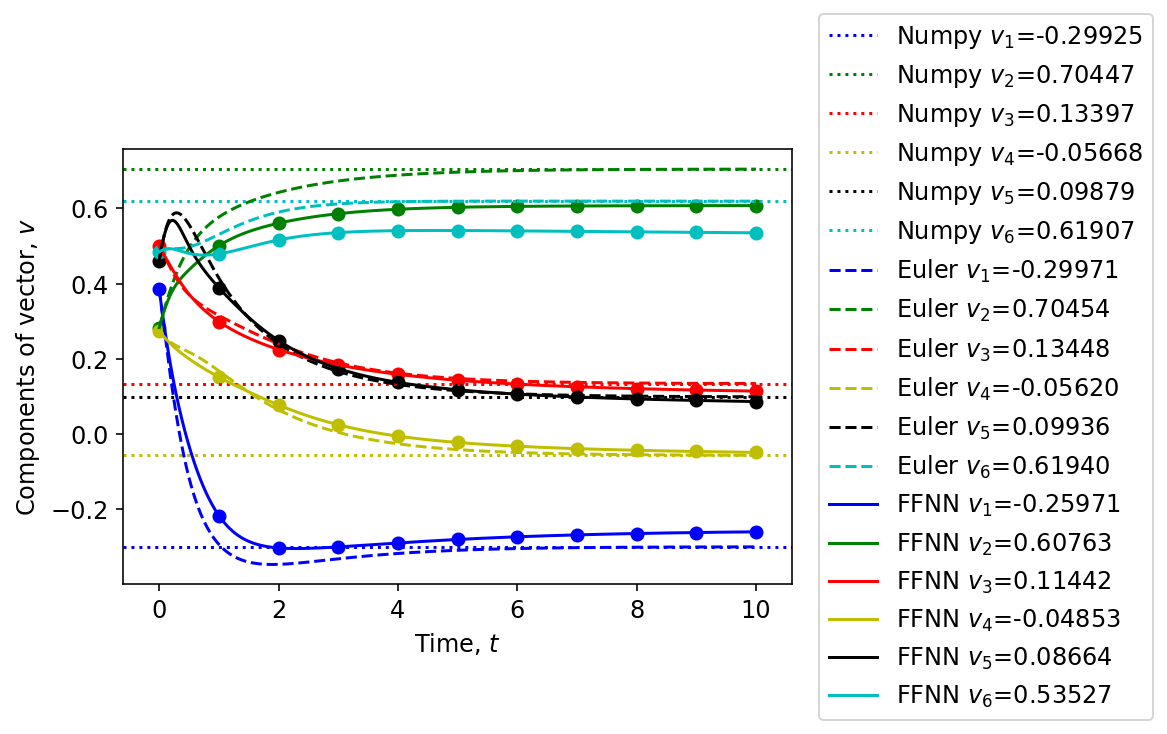

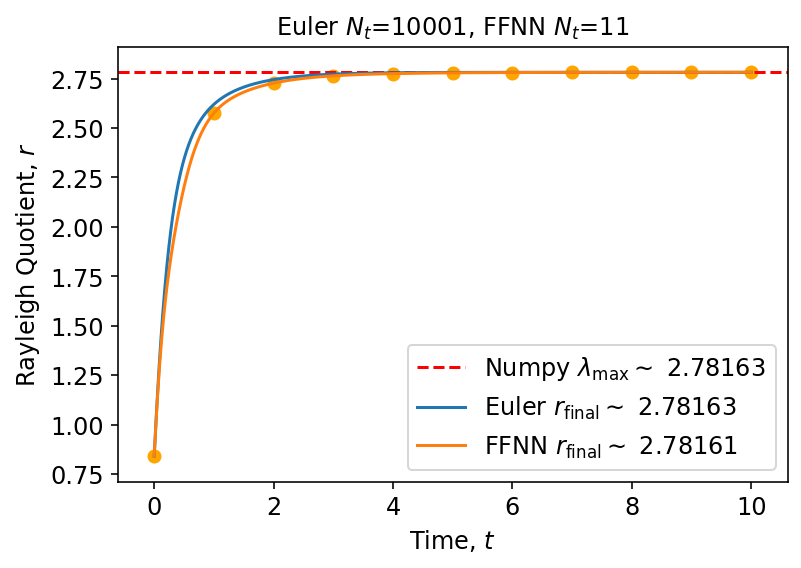

In [71]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))


@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    return tf.einsum('ij,jk,ik->i', x, A, x) / tf.einsum('ij,ij->i', x, x)

# Define Euler's method
def euler_ray_quo(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    ray_quo = np.einsum('ij,jk,ik->i', x, A, x) / np.einsum('ij,ij->i', x, x)

    return x, ray_quo

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(43)
tf.random.set_seed(43)
n = 6     # Dimension
T = 10    # Final time
N = 10001  # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0)

# Problem formulation for tensorflow
Nt = 11   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_ray_quo(A, x0, T, N)

s = t.reshape(-1, 1)
g = trial_solution(model, x0_tf, s)
g_points = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)
eig_nn_points = ray_quo(A_tf, g_points)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

fig0, ax0 = plt.subplots()
ax0.axhline(-w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={-w[0, np.argmax(v)]:.5f}')
ax0.axhline(-w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={-w[1, np.argmax(v)]:.5f}')
ax0.axhline(-w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={-w[2, np.argmax(v)]:.5f}')
ax0.axhline(-w[3, np.argmax(v)], color='y', ls=':', label=f'Numpy $v_4$={-w[3, np.argmax(v)]:.5f}')
ax0.axhline(-w[4, np.argmax(v)], color='k', ls=':', label=f'Numpy $v_5$={-w[4, np.argmax(v)]:.5f}')
ax0.axhline(-w[5, np.argmax(v)], color='c', ls=':', label=f'Numpy $v_6$={-w[5, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t, x_euler[:, 3], color='y', ls='--', label=f'Euler $v_4$={x_euler[-1, 3]:.5f}')
ax0.plot(t, x_euler[:, 4], color='k', ls='--', label=f'Euler $v_5$={x_euler[-1, 4]:.5f}')
ax0.plot(t, x_euler[:, 5], color='c', ls='--', label=f'Euler $v_6$={x_euler[-1, 5]:.5f}')
ax0.plot(s, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(s, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(s, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.plot(s, g[:, 3], color='y', label=f'FFNN $v_4$={g[-1, 3]:.5f}')
ax0.plot(s, g[:, 4], color='k', label=f'FFNN $v_5$={g[-1, 4]:.5f}')
ax0.plot(s, g[:, 5], color='c', label=f'FFNN $v_6$={g[-1, 5]:.5f}')
ax0.scatter(t_tf, g_points[:, 0], color='b')
ax0.scatter(t_tf, g_points[:, 1], color='g')
ax0.scatter(t_tf, g_points[:, 2], color='r')
ax0.scatter(t_tf, g_points[:, 3], color='y')
ax0.scatter(t_tf, g_points[:, 4], color='k')
ax0.scatter(t_tf, g_points[:, 5], color='c')
ax0.set_ylabel('Components of vector, $v$')
ax0.set_xlabel('Time, $t$')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_final1.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(s, eig_nn)
ax.scatter(t_tf, eig_nn_points, color='orange')
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_final1.pdf"), bbox_inches='tight')
plt.show()